# TD Lambda + Tile Coding for Heartbeat prediction

Import libraries: numpy, tile_coding

tile_coding is our own library to be used as a linear approximation function.

In [1]:
import numpy as np
from tile_coding import *

## 1. TD Lambda with tile coding for nexting

* What we need more for this part

1.We need to reconsider the reward function.


2.Hyperparameters?

In [109]:
class Nexting:
    
    def __init__(self, reward_batch=1, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # lower, 0 and upper beat
        self.state = (0,0)  # current heartbeat, predicted amount of change
        self.reward_batch = reward_batch
        self.exp_rate = exp_rate
        self.gamma = 1
        self.end = False
        self.n = n  # step of learning
        self.debug = debug
        self.step_num = 0
        
    def reset(self):
        pos = np.random.uniform(-0.3, 0.4) #?min max
        self.end = False
        self.state = (pos, 0)
        
    def takeAction(self, action):
        pos, gap = self.state
        
        #gap_new = gap + 0.001*action - 0.0025*np.cos(3*pos) #?
        gap_new = gap + 0.001*action
        gap_new = min(max(gap_new, GAP_BOUND[0]), GAP_BOUND[1])
        
        pos_new = pos + gap_new
        pos_new = min(max(pos_new, POSITION_BOUND[0][0]), POSITION_BOUND[0][1]) # need to change
        
        if pos_new == POSITION_BOUND[0][0]: #?
            #reach leftmost, set gap to 0
            gap_new = 0.01 # non zero
            
        elif pos_new == POSITION_BOUND[0][1]:
            gap_new = -0.01
             
        self.state = (pos_new, gap_new)
        
        return self.state ###
    
    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self): # ***
        
        self.step_num += 1
        
        if self.step_num >= len(data):
            self.step_num = len(data) - 1
        
        if self.step_num % self.reward_batch == 0:
            pos, _ = self.state
            true_pos = data[self.step_num]
            
            if pos >= true_pos - 0.005 and pos <= true_pos + 0.005:
                return 0
        
        if self.step_num == len(data) - 1:
            self.end = True
        
        return -1
        
    def play(self, valueFunction, rounds=1):
        states_per_rounds = []
        
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward
                    
                    states.append(state)
                    rewards.append(reward)
                    
                    if self.end:
                        if self.debug:
                            if rnd % 100 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state, len(states)))
                        T = t+1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau+1, min(tau+self.n+1, T+1)):
                        G += np.power(self.gamma, i-tau-1)*rewards[i]
                    if tau+self.n < T:
                        state = states[tau+self.n]
                        G += np.power(self.gamma, self.n)*valueFunction.value(state, actions[tau+self.n])
                    # update value function
                    state = states[tau]  # tau is the state to update
                    valueFunction.update(state, actions[tau], G)
                    
                if tau == T-1:
                    break
                
                t += 1
                
            states_per_rounds.append(states)
        
        return states_per_rounds

## 2. Loading the dataset

Please run the cell below if you don't have neurokit2 and mne as your python libraries. In case you have these two, you don't need to run the cell.

In [ ]:
!pip install neurokit2
!pip install mne

In [3]:
import pandas as pd
from sklearn.preprocessing import normalize
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt

In [130]:
file = "data/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

# feature range
POSITION_BOUND = [] #? range of heartbeat
for i in range(len(raw_data)):
    POSITION_BOUND.append([min(raw_data[i]), max(raw_data[i])])

Extracting EDF parameters from /Users/Textory/Desktop/Fall2022/cmput655/data/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 3. Settings to run TD lambda model for the dataset

* What we need more for this part

1.The experiment here is only for the first row of the dataset. We can use a simple loop for applying the model to our entire dataset.


2.We need to implement a progress bar of the model.


3.We need to change some hyper parameters.

In [131]:
data = raw_data[0]
GAP_BOUND = [-0.01, 0.01] #?
ACTIONS = [-1, 0, 1]
reward_batch = 300

feature_ranges = [POSITION_BOUND[0], GAP_BOUND]  # 2 features
number_tilings = 8
bins = [[16, 16] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], number_tilings), np.linspace(GAP_BOUND[0], GAP_BOUND[1], number_tilings))]

tilings = createTilings(feature_ranges, number_tilings, bins, offsets)

print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

valueFunc = qvalueFunction(tilings, ACTIONS, 0.3)

mc = Nexting(reward_batch=reward_batch)
predicted_states = mc.play(valueFunc, rounds=1)

tiling shape: 
 (8, 2, 15)
offsets: 
 [[-0.3326277028214003, -0.01], [-0.22827675655421997, -0.0071428571428571435], [-0.12392581028703961, -0.004285714285714286], [-0.01957486401985925, -0.0014285714285714284], [0.08477608224732108, 0.0014285714285714284], [0.18912702851450147, 0.004285714285714285], [0.2934779747816818, 0.0071428571428571435], [0.39782892104886214, 0.01]]


## 4. Visualisation

* What we need more for this part

1.We need to draw a graphs to compare real heartbeat / predicted heartbeat values.

### Comparing between true data and predicted results

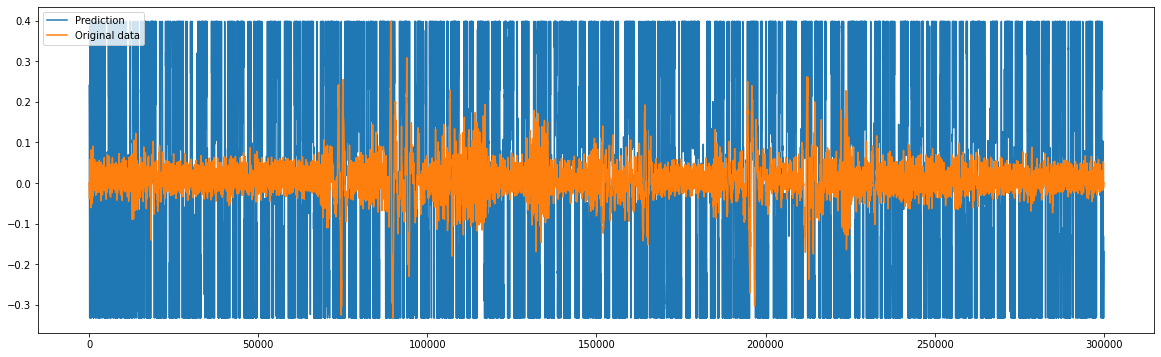

In [132]:
grids = len(data)
time_step = np.linspace(1, len(data), len(data))

predicted_positions = []

for i in range(len(data)):
    predicted_positions.append(predicted_states[0][i][0])

plt.figure(figsize=(20,6))
plt.plot(time_step, predicted_positions, label = "Prediction")
plt.plot(time_step, data, label = "Original data")
plt.legend()
plt.show()
#linestyle=":"

### RMSE Prop

In [133]:
import math

start = 0
end = 0
RMSE_value = []

for i in range(1, len(data)):
    
    if i % reward_batch == 0:
        
        start = end
        end = end + reward_batch
        
        true_batch = data[:end]
        predict_batch = predicted_positions[:end]
        
        MSE = np.square(np.subtract(true_batch,predict_batch)).mean()
        RMSE = math.sqrt(MSE)
        
        RMSE_value.append(RMSE)
        

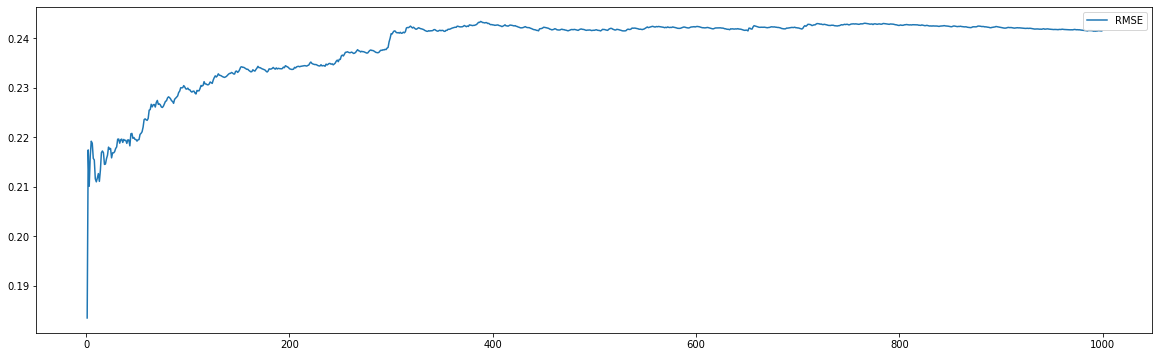

In [134]:
grids = len(RMSE_value)
step = np.linspace(1, len(RMSE_value), len(RMSE_value))

plt.figure(figsize=(20,6))
plt.plot(step, RMSE_value, label = "RMSE")

plt.legend()
plt.show()

### Cost graph

Text(0.5, 0, 'Cost')

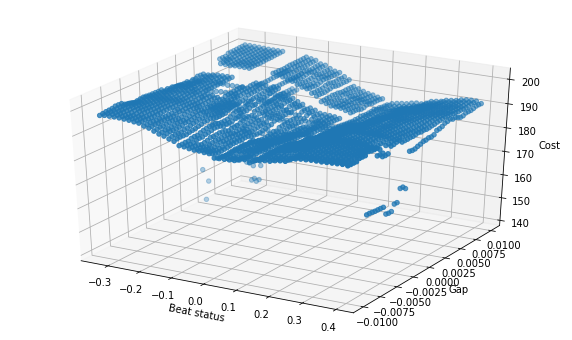

In [135]:
grids = 50

positions = np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], grids)
vels = np.linspace(GAP_BOUND[0], GAP_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.stepcost([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Beat status")
ax.set_ylabel("Gap")
ax.set_zlabel("Cost")